<a href="https://colab.research.google.com/github/Cams75018/Velib_predictions/blob/master/LSTM_multistep_min_par_min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
import datetime

### **Parametres**

In [0]:
import timeit
start_time = timeit.default_timer()

In [0]:
heurefin=9   # heure de test de la journée et donc cut du dataset au dernier jour à cette heure
minute=15
heuredebut=datetime.datetime(2020,1,29,9,15,0)
nsteps_in, nsteps_out = 90, 30
epok =5

In [37]:

df=pd.read_csv("https://raw.githubusercontent.com/alexisgcomte/velib-prediction/master/3.%20Modeling%20Research/datasets/madeleine_weekday.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (14800, 5)


,Unnamed: 0,availiable_docks,date,weekday,hour
0,0,8,2020-01-15 10:17:00,Wednesday,10
1,1,8,2020-01-15 10:18:00,Wednesday,10
2,2,7,2020-01-15 10:19:00,Wednesday,10
3,3,8,2020-01-15 10:20:00,Wednesday,10
4,4,8,2020-01-15 10:21:00,Wednesday,10


In [0]:
df['datedate'] = pd.to_datetime(df['date'])


In [39]:
# on repère l'index de la dernière minutes à prédire
lastindex=df[df.datedate==heuredebut].index.max()
dfx=df.iloc[0:lastindex+1,:]
dfx.tail()

,Unnamed: 0,availiable_docks,date,weekday,hour,datedate
13891,13891,3,2020-01-29 09:11:00,Wednesday,9,2020-01-29 09:11:00
13892,13892,3,2020-01-29 09:12:00,Wednesday,9,2020-01-29 09:12:00
13893,13893,3,2020-01-29 09:13:00,Wednesday,9,2020-01-29 09:13:00
13894,13894,3,2020-01-29 09:14:00,Wednesday,9,2020-01-29 09:14:00
13895,13895,3,2020-01-29 09:15:00,Wednesday,9,2020-01-29 09:15:00


In [0]:
#dfx=df[(df.hour==heurefin-1) | (df.hour== heurefin)]
#lastindex=dfx.index.max()
for i in range(lastindex,lastindex +1+ nsteps_out,1):
  dfx.loc[i]=df.iloc[i,:]
dfx.reset_index(inplace=True)


In [0]:
#for ind in range(len(df)-1, -int(len(df)/10)  , -1):
#   if df.hour[ind]==heurefin:
#     print(df.date[ind],ind, len(df))
#     findf=ind
#     break

In [42]:
df2=dfx.loc[:dfx.index.max(),['date','availiable_docks']]
#df3.sort_values('datenew', inplace=True, ascending=True)
#df3 = df3.reset_index(drop=True)
print('Number of rows and columns:',dfx.shape)
print(df2.date.min())
print(df2.date.max())
df2.columns=["datenew","TOTALFD"]


Number of rows and columns: (13926, 7)
2020-01-15 10:17:00
2020-01-29 09:45:00


In [43]:
df3=df2.loc[:len(df2)-1-nsteps_out,["datenew","TOTALFD"]]
df3.tail()

,datenew,TOTALFD
13891,2020-01-29 09:11:00,3
13892,2020-01-29 09:12:00,3
13893,2020-01-29 09:13:00,3
13894,2020-01-29 09:14:00,3
13895,2020-01-29 09:15:00,3


In [44]:
print('Number of rows and columns after removing missing values:', df3.shape)
print('The time series starts from: ', df3.datenew.min())
print('The time series ends on: ', df3.datenew.max())

Number of rows and columns after removing missing values: (13896, 2)
The time series starts from:  2020-01-15 10:17:00
The time series ends on:  2020-01-29 09:15:00


### First Time series plot

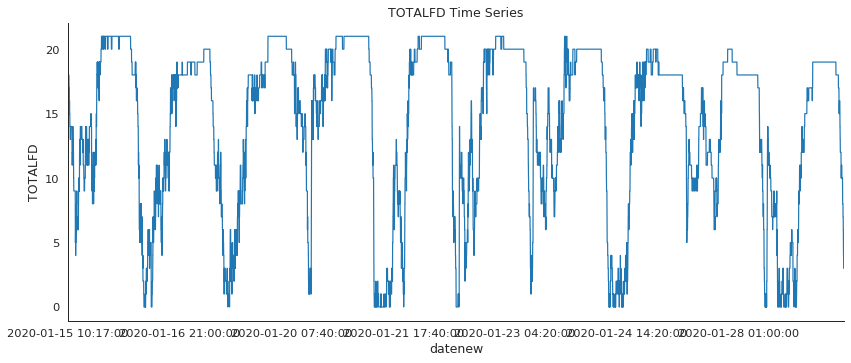

In [45]:
df4=df3.loc[:,['datenew','TOTALFD']]
df5=df3.loc[:,['datenew','TOTALFD']]
df4.set_index('datenew',inplace=True)
df4.plot(figsize=(12,5))
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('TOTALFD Time Series')
sns.despine(top=True)
plt.show();

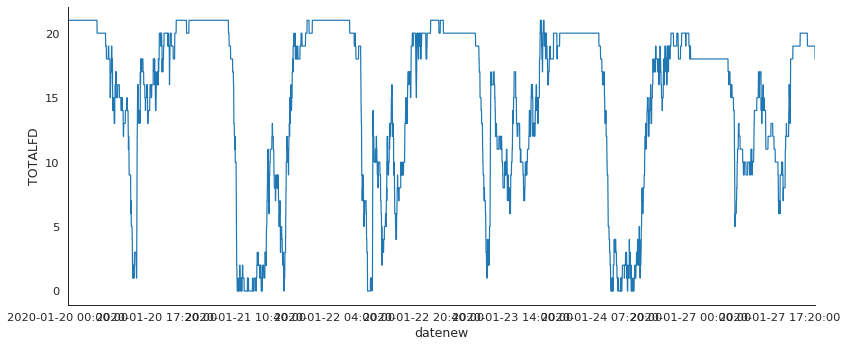

In [46]:
df5=df4[(df4.index>='2020-01-20') & (df4.index<'2020-01-28')]
df5.plot(figsize=(12,5));
plt.ylabel('TOTALFD')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

### TOTALFD Distribution

,count,mean,std,min,25%,50%,75%,max
TOTALFD,13896.0000,14.3914,6.4514,0.0000,10.0000,17.0000,20.0000,21.0000


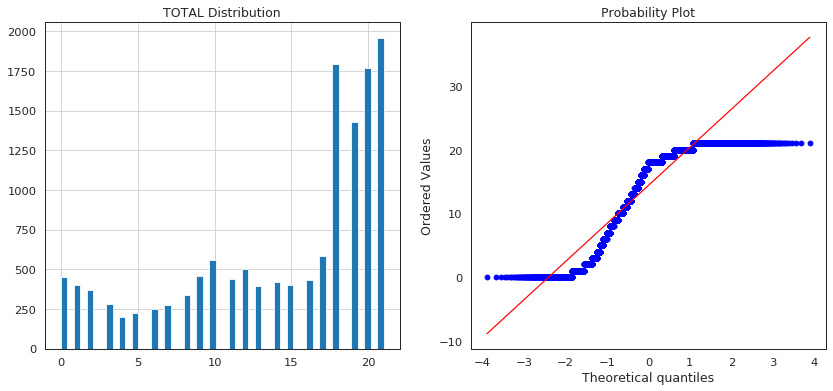

In [47]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df3['TOTALFD'].hist(bins=50)
plt.title('TOTAL Distribution')

plt.subplot(1,2,2)
stats.probplot(df3['TOTALFD'], plot=plt);
df3.describe().T

Normal probability plot also shows the data set is far from normally distributed.

**MULTI-STEP LSTM**

In [0]:
from sklearn.preprocessing import MinMaxScaler

LSTM multi-step encoder -decoder step_in 96, setp out 5 couche 100  normalisé

In [49]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    # check if we are beyond the sequence
    if out_end_ix > len(sequence):
      break
  # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
scaler = MinMaxScaler(feature_range=(-1, 1))
raw_seq = df3.TOTALFD.to_numpy()
#normalisation
raw_seq_scaled = scaler.fit_transform(raw_seq.reshape(-1,1))
#raw_seq_scaled = scaled_values.reshape(1,len(raw_seq_scaled)  )
# choose a number of time steps

n_steps_in, n_steps_out = nsteps_in, nsteps_out

X, y = split_sequence(raw_seq_scaled, n_steps_in, n_steps_out)
X=X.reshape(X.shape[0],X.shape[1])
y= y.reshape(y.shape[0],y.shape[1])
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
#model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=epok) # verbose=0)
# demonstrate prediction
#x_input = array(raw_seq[-n_steps_in:])
# Normalisation du "Test"
X_input_scal=scaler.transform(array(raw_seq[-n_steps_in:]).reshape(-1,1))
X_input_scal.reshape(X_input_scal.shape[0],)
X_input_scal = X_input_scal.reshape((1, n_steps_in, n_features))
#x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(X_input_scal, verbose=0)
yhat=scaler.inverse_transform(yhat.reshape(yhat.shape[0],yhat.shape[1]))
elapsed = timeit.default_timer() - start_time
print(yhat)

Epoch 1/5
13807/13807 [==============================] - 62s 4ms/step - loss: 0.0461
Epoch 2/5
13807/13807 [==============================] - 61s 4ms/step - loss: 0.0297
Epoch 3/5
13807/13807 [==============================] - 60s 4ms/step - loss: 0.0288
Epoch 4/5
13807/13807 [==============================] - 60s 4ms/step - loss: 0.0282
Epoch 5/5
13807/13807 [==============================] - 60s 4ms/step - loss: 0.0281
[[3.6629257 3.3820443 3.4426959 3.5395985 3.5945425 3.6257796 3.6524422
  3.6848454 3.7237751 3.7675989 3.8137815 3.859949  3.9040153 3.9438999
  3.9797785 4.0114884 4.0390735 4.062743  4.0828605 4.0997868 4.113877
  4.1254945 4.1349864 4.1426816 4.14887   4.1538095 4.1577225 4.1607995
  4.1632013 4.165059 ]]


**Visualisation predictions**

In [50]:


dfres=df2.tail(n_steps_out*3)
dfres["pred"]=0.0
dfres = dfres.reset_index()
#lastindex=dfres.tail(1).index.start
yhat2=pd.DataFrame(yhat.reshape(n_steps_out,1))
for ind in range(len(dfres)-1, -len(yhat2) + len(dfres)-1 , -1):
   dfres["pred"][ind]=yhat2.iloc[ind-len(dfres)]
dfres.tail(n_steps_out)



,index,datenew,TOTALFD,pred
60,13896,2020-01-29 09:16:00,0,3.6629
61,13897,2020-01-29 09:17:00,0,3.3820
62,13898,2020-01-29 09:18:00,1,3.4427
63,13899,2020-01-29 09:19:00,1,3.5396
64,13900,2020-01-29 09:20:00,1,3.5945
65,13901,2020-01-29 09:21:00,1,3.6258
66,13902,2020-01-29 09:22:00,1,3.6524
67,13903,2020-01-29 09:23:00,1,3.6848
68,13904,2020-01-29 09:24:00,0,3.7238
69,13905,2020-01-29 09:25:00,0,3.7676


In [51]:
from math import sqrt
from sklearn.metrics import mean_squared_error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
msedf=dfres.tail(n_steps_out)
heurefin=heuredebut+datetime.timedelta(minutes=nsteps_out)
print("RMSE ",measure_rmse(msedf.TOTALFD,msedf.pred))
print("RMSE prédictions arrondies ", measure_rmse(msedf.TOTALFD,round(msedf.pred)))
print("nb epoch", epok)
print("nb stepIN", nsteps_in)
print("nb stepOUT", nsteps_out)
print("prédiction de ",heuredebut.hour,"h",heuredebut.minute," à " ,heurefin.hour,"h",heurefin.minute,"min")
print("temps d'execution " , int(elapsed/60), "min", int((round(elapsed/60,2,)-(int(elapsed/60)))*60), "s")

RMSE  3.695216660987403
RMSE prédictions arrondies  3.7058512292499457
nb epoch 5
nb stepIN 60
nb stepOUT 30
prédiction de  9 h 15  à  9 h 45 min
temps d'execution  5 min 6 s


In [52]:
heurefin=heuredebut+datetime.timedelta(minutes=nsteps_out)
heurefin

datetime.datetime(2020, 1, 29, 9, 45)

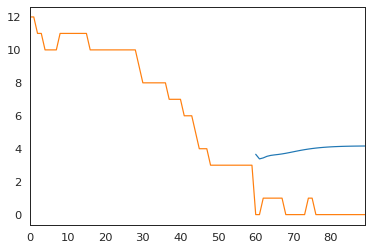

In [53]:

import matplotlib.pyplot as plt
dfres['pred'].tail(n_steps_out).plot()
dfres['TOTALFD'].plot()


# code you want to evaluate
elapsed = timeit.default_timer() - start_time
